# 0.0. Entender o Problema

-- Objetivo do Problema: 
    -- 1.0. Previsão do primeiro destino que um novo usuário irá escolher.
    
    -- Porque?
        -- Qual o tipo de modelo de negócio do Airbnb?
            -- MarketPlace (Conecta pessoas que oferecem acomodação com pessias que estão procurando acomodação.)
            -- Oferta (Pessoas oferecendo acomodação)
                -- Métricas
                -- Tamanho do Portfólio
                -- Diversidade/Densidade de portfólio
                -- Preco Medio
                
            -- Demanda (Pessoas procurando acomodação)
                -- Número de Usuários
                -- LTV (Lifetime Value)
                -- CAC (Client Acquisition Cost)
                
                Gross Revenue = (Fee * Numero Clientes) - CAC
                
    
-- Proposta da Solução

    --- Modelo de Previsão do primeiro destino de um novo suário
    --- 1.0. Predicoes salvar em uma tabela em um banco de dados
    --- 2.0. API
            --- Input: usuario e suas caracteristicas
            --- output: usuario e suas caracteristicas com a **predição do destino**
            
    --- 16 ciclos

# <font color='red'> Ciclo01: End to End</font>

# 0.0. Imports

In [47]:
import random
import pandas                   as pd
import seaborn                  as sns
import warnings
import matplotlib
import matplotlib.pyplot        as plt 


from keras                      import models as ml
from keras                      import layers
from sklearn                    import preprocessing
from sklearn                    import metrics
from scikitplot                 import metrics as  mt
from sklearn.model_selection    import train_test_split
from IPython.core.display       import HTML

## 0.1. Funções Auxiliares

In [2]:
def jupyter_settings():
    """ Optimize general settings, standardize plot sizes, etc. """
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 20
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
    sns.set()
    pd.set_option('display.float_format', '{:.2f}'.format)
jupyter_settings()



warnings.filterwarnings('ignore')

## 0.2. Carregando Dados

In [3]:
# Granularidade: Usuário
df_raw = pd.read_csv('data/train_users_2.csv')
df_raw.shape

(213451, 16)

In [4]:
# # Granularidade: Ação
# df_sessions = pd.read_csv('data/sessions.csv')
# df_sessions.shape

# 1.0. Descrição dos Dados

In [5]:
df1 = df_raw.copy()

In [6]:
print( f"Número de linhas: {df1.shape[0]} ")
print( f"Número de colunas: {df1.shape[1]} ")

Número de linhas: 213451 
Número de colunas: 16 


## 1.1. Tipo de Dados

In [7]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.2. Checando Valores Ausentes

In [8]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [9]:
# Removendo so dados ausentes completamente
df1 = df1.dropna()
df1.shape

(68171, 16)

## 1.3. Mudando Tipo de Dados

In [10]:
# date_account_created  
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( 'int64' )

## 1.4. Checando dados desbalanceados

In [11]:
df1.country_destination.value_counts( normalize=True)

US      0.71
other   0.11
FR      0.05
IT      0.03
GB      0.03
ES      0.02
CA      0.02
DE      0.01
NL      0.01
AU      0.01
PT      0.00
Name: country_destination, dtype: float64

# 2.0. Filtragem dos Dados

In [12]:
df2 = df1.copy()

## 2.1. Filtrando Linhas

## 2.2. Selecionando colunas

# 3.0. Preparação dos dados

In [13]:
df3 = df2.copy()

In [14]:
# Variáveis Dummy
df3_dummy = pd.get_dummies( df3.drop(['id', 'country_destination'], axis=1) )

# Join Id e country_destination
df3 = pd.concat( [df3[['id', 'country_destination']], df3_dummy], axis=1)

# 4.0. Feature Selection

In [15]:
# Datas originais
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking']

df4  = df3.drop( cols_drop, axis=1)

In [16]:
X = df4.drop( ['id', 'country_destination'], axis=1)
y = df4['country_destination'].copy()

In [17]:
# Divisão do dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=32)

# 5.0. Modelo de Machine Learning 

## 5.1. Baseline Model

In [56]:
country_destination_list = sorted(df1.country_destination.unique().tolist())
country_destination_weights = df1.country_destination.value_counts(normalize=True).sort_index().tolist()
k_num = y_test.shape[0]

yhat_random = random.choices(population=country_destination_list, 
                             weights=country_destination_weights,
                             k=k_num)
len(yhat_random)

13635

Acurácia: 0.5221122112211221
Acurácia Balanceada: 0.09335215861648685
Kappa Score: 0.002885678698561933
              precision    recall  f1-score   support

          AU       0.01      0.01      0.01       101
          CA       0.02      0.02      0.02       214
          DE       0.02      0.02      0.02       170
          ES       0.03      0.03      0.03       345
          FR       0.04      0.04      0.04       710
          GB       0.03      0.03      0.03       344
          IT       0.03      0.03      0.03       423
          NL       0.01      0.01      0.01       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.71      0.71      9624
       other       0.12      0.12      0.12      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.52      0.52      0.52     13635



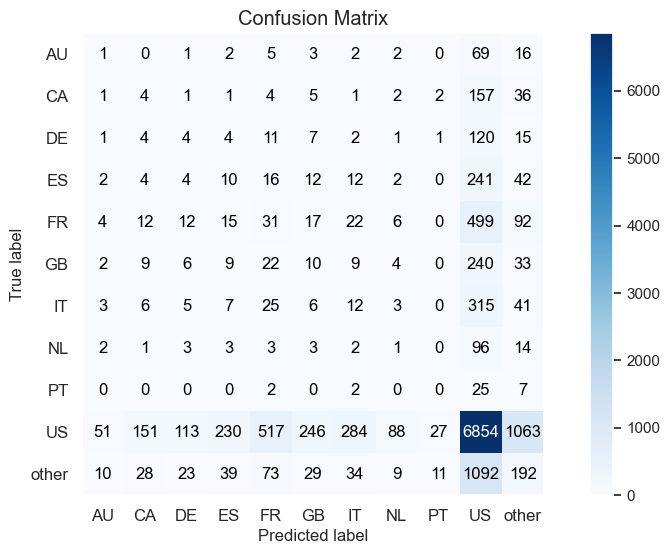

In [57]:
# Acurácia
acc_random = metrics.accuracy_score(y_test_nn, yhat_random)
print(f"Acurácia: {acc_random}")

# Balanced Acuracy
balanced_acc_random = metrics.balanced_accuracy_score(y_test_nn, yhat_random)
print(f"Acurácia Balanceada: {balanced_acc_random}")

# Kappa Metrics
kappa_random = metrics.cohen_kappa_score(y_test_nn, yhat_random)
print(f"Kappa Score: {kappa_random}")

# Classification Report
print( metrics.classification_report( y_test_nn, yhat_random) )

# Matriz de Confusão
mt.plot_confusion_matrix( y_test_nn, yhat_random, normalize=False);

## 5.2. Neural Network - Multi-Layer Perceptron

In [18]:
ohe = preprocessing.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape(-1,1) ).toarray()

In [19]:
# definição do modelo
model = ml.Sequential()
model.add( layers.Dense( 128, input_dim = X_train.shape[1], activation='relu' ) )
model.add( layers.Dense( 11, activation='softmax' ) )

# compilando o modelo
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# treinando o modelo
model.fit( X_train, y_train_nn, epochs=100)

Epoch 1/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.3322 - accuracy: 0.7029
Epoch 2/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.2643 - accuracy: 0.7074
Epoch 3/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2287 - accuracy: 0.7082
Epoch 4/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1997 - accuracy: 0.7085
Epoch 5/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1867 - accuracy: 0.7086
Epoch 6/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.1751 - accuracy: 0.7086
Epoch 7/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1625 - accuracy: 0.7085
Epoch 8/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1492 - accuracy: 0.7089
Epoch 9/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1454 - accuracy: 0.7088
Epoch 10/100
1705/1705 [==============================] - 4s 2ms/step - l

1705/1705 [==============================] - 4s 2ms/step - loss: 1.0991 - accuracy: 0.7120
Epoch 80/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0991 - accuracy: 0.7118
Epoch 81/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0995 - accuracy: 0.7119
Epoch 82/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.1004 - accuracy: 0.7118
Epoch 83/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.0980 - accuracy: 0.7120
Epoch 84/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.0979 - accuracy: 0.7119
Epoch 85/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0986 - accuracy: 0.7120
Epoch 86/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.0979 - accuracy: 0.7123
Epoch 87/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.0977 - accuracy: 0.7121
Epoch 88/100
1705/1705 [==============================] - 4s 2ms/step - loss:

## 5.1. Performace da NN

In [20]:
# predicao
pred_nn =  model.predict( X_test )

# inverter o One Hot Encoding
yhat_nn = ohe.inverse_transform( pred_nn )

# preparação para métricas
y_test_nn = y_test.to_numpy()
y_hat_nn=yhat_nn.reshape(1, -1) [0] 

427/427 [==============================] - 1s 1ms/step


Acurácia: 0.7041437477081042
Acurácia Balanceada: 0.09156424487315175
Kappa Score: 0.0019935963379111854
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.20      0.01      0.01       170
          ES       0.00      0.00      0.00       345
          FR       0.00      0.00      0.00       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.27      0.00      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.11      0.09      0.08     13635
weighted avg       0.53      0.70      0.58     13635



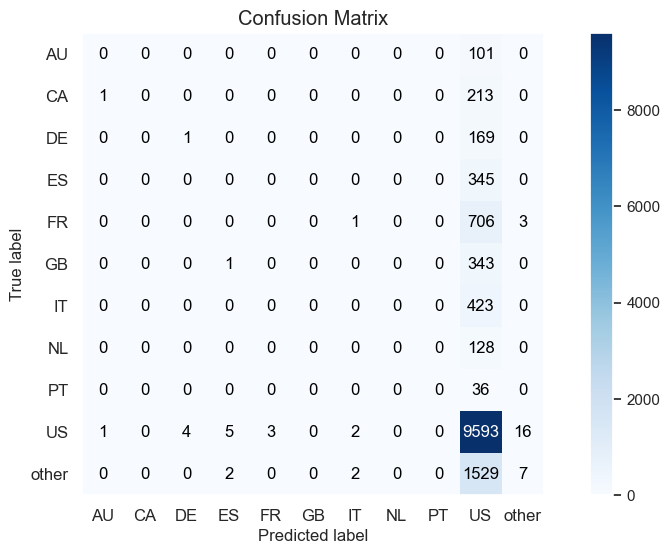

In [30]:
# Acurácia
acc_nn = metrics.accuracy_score(y_test_nn, y_hat_nn)
print(f"Acurácia: {acc_nn}")

# Balanced Acuracy
balanced_acc_nn = metrics.balanced_accuracy_score(y_test_nn, y_hat_nn)
print(f"Acurácia Balanceada: {balanced_acc_nn}")

# Kappa Metrics
kappa_nn = metrics.cohen_kappa_score(y_test_nn, y_hat_nn)
print(f"Kappa Score: {kappa_nn}")

# Classification Report
print( metrics.classification_report( y_test_nn, y_hat_nn) )

# Matriz de Confusão
mt.plot_confusion_matrix( y_test_nn, y_hat_nn, normalize=False);

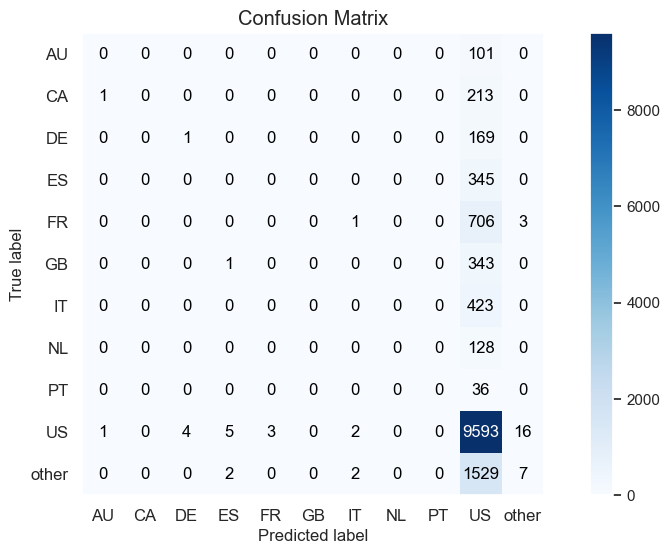

# PAREI Faltando 47:33